# 1. INTRODUCCIÓN 

En este notebook podemos encontrar el análisis que hemos hecho para la reducción de la dimensionalidad para los datos de características (features). Este pequeño análisis nos ayudará a reducir la complexidad del problema (para el algoritmo) y los tiempos de cómputo. El resultado obtenido es de 16 componentes las cuales consiguen mantener un porcentaje de varianza explicada acumulada del casi el 90%.  

## 1.1 ¿Por qué PCA?

Como en cualquier análisis, el investigador lo que quiere es poder explicar la relación entre las variables con los datos disponibles. Muchas veces esto se complica cuando el número de variables es alto, por lo que intentar realizar una reducción de la dimensionalidad del conjunto de datos (reducir numero de variables) perdiendo la mínima informacion posible, ayudaria a entender mejor el _por qué_ de los datos. Aquí es donde entra en juego el Análisis de Componentes Principales o ACP (o PCA inglés). 

PCA no deja de ser un métodos de aprendizaje no supervisado (no tenemos una variable objetivo con etiquetas) y una de sus funciones es extraer información útil a partir de las variables originales. Esto nos ayudará a simplificar análisis posteriores como la representación de los datos en dos o tres dimensiones. 

## 1.2 Definición de conceptos básicos 

### 1.2.1 Valor y vector propios

Sin entrar en detalles de como se caluclan (descomposición espectral), _definimos_ ambos conceptos como:

* __Eigenvectors__ (vectores própios): son un caso particular de multiplicación entre una matriz y un vector. El vector resultante de la multiplicación es un múltiplo entero del vector original. Los eigenvectors de una matriz son todos aquellos vectores que, al multiplicarlos por dicha matriz, resultan en el mismo vector o en un múltiplo entero del mismo 

* __Eigenvalues__ (valores própios o autovalores): Cuando se multiplica una matriz por alguno de sus eigenvectors se obtiene un múltiplo del vector original, es decir, el resultado es ese mismo vector multiplicado por un número. Al valor por el que se multiplica el eigenvector resultante se le conoce como eigenvalue. A todo eigenvector le corresponde un eigenvalue y viceversa. 

### ¿Pero, por qué debemos calcularlos?

Basicamente, los **eigenvectors ordenados de mayor a menor eigenvalues se corresponden con las componentes principales**. 

# 2. PCA (Principal Component Analysis)


## 2.1 Importación de librerias

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re


# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)


## 2.2. Tratamiento de los datos

### 2.1.1 Datos: Features:


Procedemos a leer las el fichero de caracteristicas:

In [34]:
features = pd.read_csv('/content/item_features.csv')
features.head(5)

,item_id,feature_category_id,feature_value_id
0,2,56,365
1,2,62,801
2,2,68,351
3,2,33,802
4,2,72,75


Exploramos un poquito el dato:

In [35]:
print('Numero de categorias únicas:\t', len(np.unique(features["feature_category_id"])), 
      '\t\t ( min:: ', min(features["feature_category_id"]), ', max: ', max(features["feature_category_id"]), ')')

print('Numero de valores únicos:\t', len(np.unique(features["feature_value_id"])), 
      '\t\t ( min:: ', min(features["feature_value_id"]), ', max: ', max(features["feature_value_id"]), ')')

print('Numero de items unicos:\t\t', len(np.unique(features["item_id"])), 
      '\t\t ( min:: ', min(features["item_id"]), ', max: ', max(features["item_id"]), ')')

Numero de categorias únicas:	 73 		 ( min::  1 , max:  73 )
Numero de valores únicos:	 890 		 ( min::  1 , max:  905 )
Numero de items unicos:		 23691 		 ( min::  2 , max:  28143 )


Sacamos una matriz numèrica _mxn_ tal que para cada item (indice fila) y característica (indice columna) tenemos su valor asociado (feature value). 

In [36]:
features_ones = features.copy()
features_ones["feature_value_id"] =1
features_ones = features_ones.dropna()
features_ones = features_ones.pivot_table(values='feature_value_id', index='item_id', columns='feature_category_id', aggfunc='first')
features_ones = features_ones.replace(np.nan, 0)
features_matrix = features.pivot_table(values='feature_value_id', index='item_id', columns='feature_category_id', aggfunc='first')

display(features_matrix)
print('\n EJEMPLO: El item 2, tiene la categoria 72 con valor 75.0: \n\n', features_matrix.loc[2])
 # 


feature_category_id,1,2,3,4,5,6,7,8,9,10,...,64,65,66,67,68,69,70,71,72,73
item_id,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,394.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,351.0,885.0,NaN,NaN,75.0,NaN
3,NaN,NaN,889.0,618.0,605.0,NaN,452.0,NaN,NaN,NaN,...,NaN,521.0,NaN,NaN,14.0,592.0,NaN,NaN,75.0,544.0
4,NaN,NaN,793.0,618.0,605.0,NaN,837.0,NaN,NaN,NaN,...,NaN,521.0,NaN,NaN,373.0,538.0,NaN,NaN,75.0,544.0
7,NaN,NaN,NaN,NaN,NaN,NaN,536.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,739.0,592.0,NaN,NaN,75.0,NaN
8,NaN,NaN,793.0,618.0,605.0,NaN,798.0,NaN,NaN,NaN,...,NaN,521.0,NaN,NaN,351.0,592.0,NaN,NaN,75.0,544.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28139,NaN,NaN,793.0,618.0,605.0,NaN,798.0,NaN,NaN,NaN,...,NaN,521.0,NaN,NaN,106.0,805.0,NaN,NaN,75.0,544.0
28140,NaN,53.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,80.0,NaN,NaN,349.0,351.0,NaN,NaN,226.0,NaN,544.0
28141,461.0,NaN,889.0,719.0,605.0,NaN,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,379.0,499.0,NaN,NaN,75.0,544.0



 EJEMPLO: El item 2, tiene la categoria 72 con valor 75.0: 

 feature_category_id
1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
      ...  
69    885.0
70      NaN
71      NaN
72     75.0
73      NaN
Name: 2, Length: 73, dtype: float64


## 2.3. Aplicación modelo PCA

Procedemos a realizar una transformación a los datos de características:

* **StandardScaler()**: La idea principal es normalizar/estandarizar ($mean = 0$ y standard $deviation = 1$) sus características antes de aplicar técnicas de aprendizaje automático. Dada la distribución de los datos, cada valor en el conjunto de datos tendrá el valor medio de la muestra restado, y luego dividido por la desviación estándar de todo el conjunto de datos.


* **PCA()**: Dado un el espacio muestral con $p$ dimensiones, la técnica PCA nos permitirá encontrar un número de factores subyacentes $z$ (donde $z< p$) que expliquen aproximadamente lo mismo que las $p$ variables originales. Donde antes se necesitaban $p$ valores para caracterizar a cada una de las prendas de ropa, ahora solo bastaran $z$ características. Cada una de estas $z$ nuevas variables recibe el nombre de componente principal (CP). En resumen, el método de PCA permite por lo tanto "condensar" la información aportada por múltiples variables en solo unas pocas componentes


In [21]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
features_scaled=ss.fit_transform(features_ones)
features_scaled= pd.DataFrame(features_scaled)

* _NOTA: Remarcar que escalar los valores tal y como hemos hecho es muy importante, ya que por defecto, PCA() centra los valores pero no los escala. Esto es vital ya que, si las variables tienen distinta dispersión, como en este caso, es necesario escalarlas puesto que las que tengan mayor valor y dispersión serian, con probabilidad alta, candidatas a CP._

Para aplicar PCA a conciencia y no a loco, lo primero que debemos entender es determinar el numero óptimo de CPs. 

 

In [22]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

# Entrenamiento modelo PCA con escalado de los datos
# ==============================================================================

pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit(features_ones)

# Se extrae el modelo entrenado del pipeline
modelo_pca = pca_pipe.named_steps['pca']

### 2.3.1 Componentes principals

Una vez entrenado el objeto PCA, podemos acceder a toda la información de las componentes creadas.

* **components_** contiene el valor de los loadings  que definen cada componente (eigenvector). Las filas se corresponden con las componentes principals (ordenadas de mayor a menor varianza explicada). Las filas se corresponden con las variables de entrada.

In [23]:
# Se combierte el array a dataframe para añadir nombres a los ejes.
pd.DataFrame(
    data    = modelo_pca.components_,
    columns = ['cat_id_' + str(x) for x in features_ones.columns],
    index = ['PC_' + str(x) for x in features_ones.columns]
).round(4)

,cat_id_1,cat_id_2,cat_id_3,cat_id_4,cat_id_5,cat_id_6,cat_id_7,cat_id_8,cat_id_9,cat_id_10,...,cat_id_64,cat_id_65,cat_id_66,cat_id_67,cat_id_68,cat_id_69,cat_id_70,cat_id_71,cat_id_72,cat_id_73
PC_1,-0.0234,0.2163,-0.1457,-0.1560,-0.1459,0.0010,-0.2238,-0.0345,-0.0100,-0.0288,...,0.1028,-0.1242,0.1304,0.2271,-0.0379,-0.2242,-0.0183,0.1028,-0.2244,-0.0716
PC_2,-0.0359,-0.1092,-0.2141,-0.0180,-0.2137,0.1653,0.0814,-0.0525,-0.0164,-0.0461,...,-0.0423,-0.0462,-0.0667,-0.1101,-0.0346,0.0826,-0.0249,-0.0423,0.0847,-0.0707
PC_3,0.0418,-0.0523,-0.0717,-0.1488,-0.0602,-0.0574,0.0061,0.3555,0.0125,0.2362,...,-0.0063,-0.2589,-0.0345,-0.0467,-0.0715,0.0077,0.2597,-0.0063,0.0104,-0.1417
PC_4,0.0353,-0.0789,-0.1185,-0.2536,-0.1150,-0.0989,-0.0162,-0.1963,0.0000,-0.1428,...,-0.0010,-0.0874,-0.0550,-0.0674,-0.1542,-0.0130,-0.1288,-0.0010,-0.0077,-0.2510
PC_5,-0.0751,-0.0017,-0.0349,-0.0011,-0.0291,-0.0756,0.0079,0.0552,-0.0282,0.0068,...,0.0005,0.0589,-0.0016,-0.0017,0.0130,0.0077,0.0759,0.0005,0.0075,0.0530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PC_69,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0604,0.0000,0.0026,0.0129,-0.0214,...,-0.0445,-0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0188,0.0445,0.0000,-0.0000
PC_70,0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0131,-0.0000,0.0042,-0.0037,0.0031,...,-0.0035,0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0887,0.0035,-0.0000,0.0000
PC_71,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0012,0.0000,0.0130,0.0044,-0.0089,...,-0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,0.3277,0.0000,0.0000,-0.0000
PC_72,0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0007,0.0000,-0.0221,-0.0013,0.0171,...,0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.5459,-0.0000,0.0000,-0.0000


Analizar con detalle el vector de loadings que forma cada componente puede ayudar a interpretar qué tipo de información recoge cada una de ellas. Por ejemplo, la primera componente es el resultado de la siguiente combinación lineal de las variables originales:

$$PC_1 = -0.0234\ Cat\_id_1 + 0.2163\ Cat\_id_2 -0.1457\ Cat\_id_3  -0.1560\ Cat\_id_4 +  ...  - 0.0716\ Cat\_id_{73}$$

Para saber que componente explica mejor cada una de las carcateristicas, debemos seleccionar para cada componente el valor más grande.

Si bien con una componente (y pocas caracteristicas/variables) puede ser facil de determinar, este no es nuestro caso. La influencia de las variables en cada componente analizarse visualmente con un gráfico de tipo heatmap.



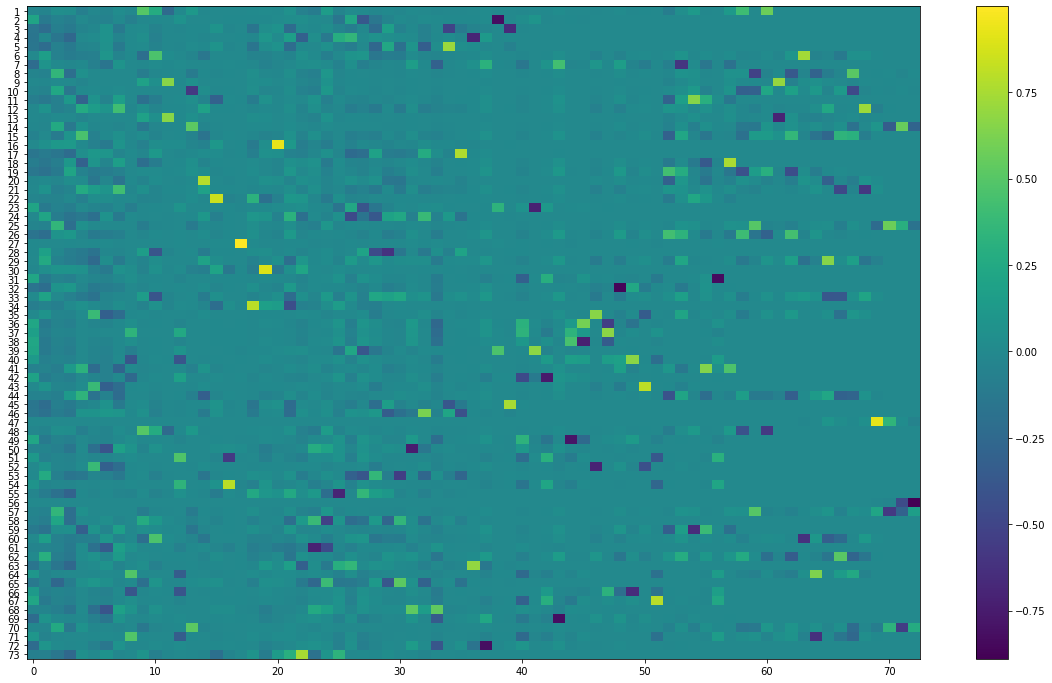

In [24]:
# Heatmap componentes
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 12))

componentes = modelo_pca.components_

plt.imshow(componentes.T, cmap='viridis', aspect='auto')
plt.yticks(range(len(features_ones.columns)), features_ones.columns)
#plt.xticks(range(len(features_ones.columns)), np.arange(features_ones.n_components_) + 1)
plt.grid(False)
plt.colorbar();

Una vez calculadas las componentes principales, se puede conocer la varianza explicada por cada una de ellas, la proporción de variancia respecto al total y la proporción de varianza acumulada. Esta información está almacenada en los atributos:
 * **explained_variance** y 
 * **explained_variance_ratio** 

del modelo.

### 2.3.2 Porcentaje de varianza explicada por cada componente

----------------------------------------------------
Porcentaje de varianza explicada por cada componente
----------------------------------------------------
[2.28496295e-01 1.22008232e-01 7.91670663e-02 6.91216191e-02
 5.36347587e-02 4.72101417e-02 4.29147236e-02 3.92397522e-02
 3.64784232e-02 3.44300325e-02 3.17572175e-02 2.84644921e-02
 2.36738888e-02 2.31697584e-02 1.85259916e-02 1.52232587e-02
 1.44972977e-02 1.41064160e-02 1.32023232e-02 1.20660546e-02
 1.10098434e-02 7.74635021e-03 5.82107098e-03 4.78666558e-03
 4.63473432e-03 3.56404615e-03 2.64006554e-03 2.31757985e-03
 2.19601354e-03 1.55648884e-03 1.01427248e-03 7.75195709e-04
 7.50765326e-04 6.21891075e-04 6.08668653e-04 4.80409167e-04
 3.36606436e-04 3.24757620e-04 3.09132497e-04 2.66275498e-04
 2.36404720e-04 2.07905842e-04 1.13728684e-04 1.04591325e-04
 5.73945127e-05 2.81311342e-05 2.64975222e-05 1.89109243e-05
 1.62889710e-05 1.53713207e-05 8.38753948e-06 5.02828802e-06
 4.27813073e-06 3.24553687e-06 2.36556390e-06 1.

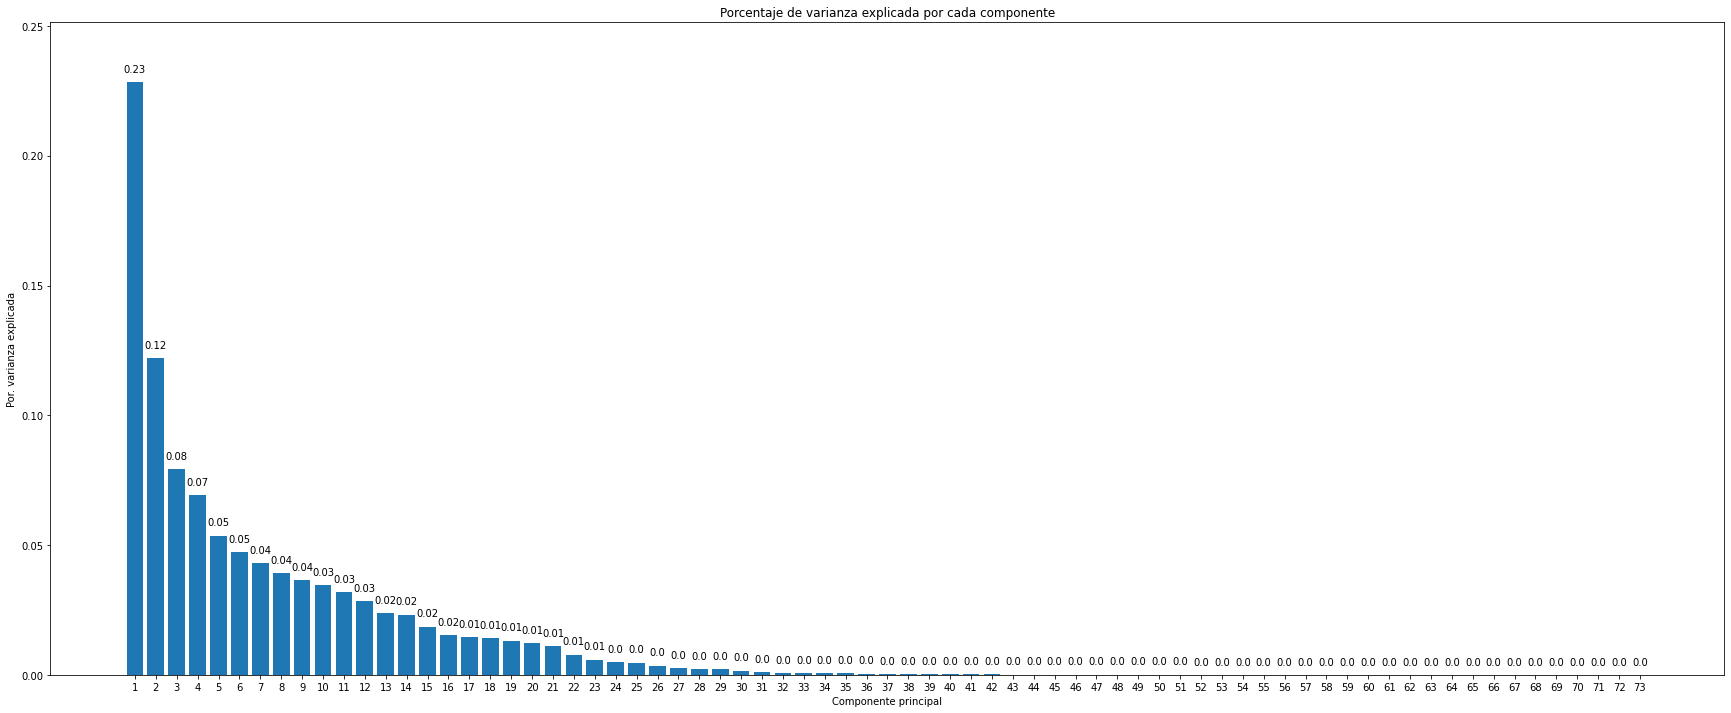

In [25]:
# Porcentaje de varianza explicada por cada componente
# ==============================================================================
print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')
print(modelo_pca.explained_variance_ratio_)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30, 12))
ax.bar(
    x      = np.arange(modelo_pca.n_components_) + 1,
    height = modelo_pca.explained_variance_ratio_
)

for x, y in zip(np.arange(len(features_ones.columns)) + 1, modelo_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_ylim(0, max(modelo_pca.explained_variance_ratio_) * 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada');

En este caso, podemos ver que:
1. La primera componente explica el 23% de la varianza observada en los datos 
2. La segunda el 12%. Las dos últimas componentes no superan por 
3. La tercera el 8%. 
4. La cuarta el 7%. 
5. La quinta el 5%
6. Etc
 
de todos modos, podemos ver que a apartir de la 17, estas nosuperan por separado el 1% de varianza explicada.

### 2.3.3 Porcentaje de varianza explicada acumulada

------------------------------------------
Porcentaje de varianza explicada acumulada
------------------------------------------
[0.22849629 0.35050453 0.42967159 0.49879321 0.55242797 0.59963811
 0.64255284 0.68179259 0.71827101 0.75270104 0.78445826 0.81292275
 0.83659664 0.8597664  0.87829239 0.89351565 0.90801295 0.92211936
 0.93532169 0.94738774 0.95839759 0.96614394 0.97196501 0.97675167
 0.98138641 0.98495045 0.98759052 0.9899081  0.99210411 0.9936606
 0.99467487 0.99545007 0.99620083 0.99682273 0.99743139 0.9979118
 0.99824841 0.99857317 0.9988823  0.99914858 0.99938498 0.99959289
 0.99970661 0.99981121 0.9998686  0.99989673 0.99992323 0.99994214
 0.99995843 0.9999738  0.99998219 0.99998722 0.99999149 0.99999474
 0.99999711 0.9999984  0.99999955 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.        ]


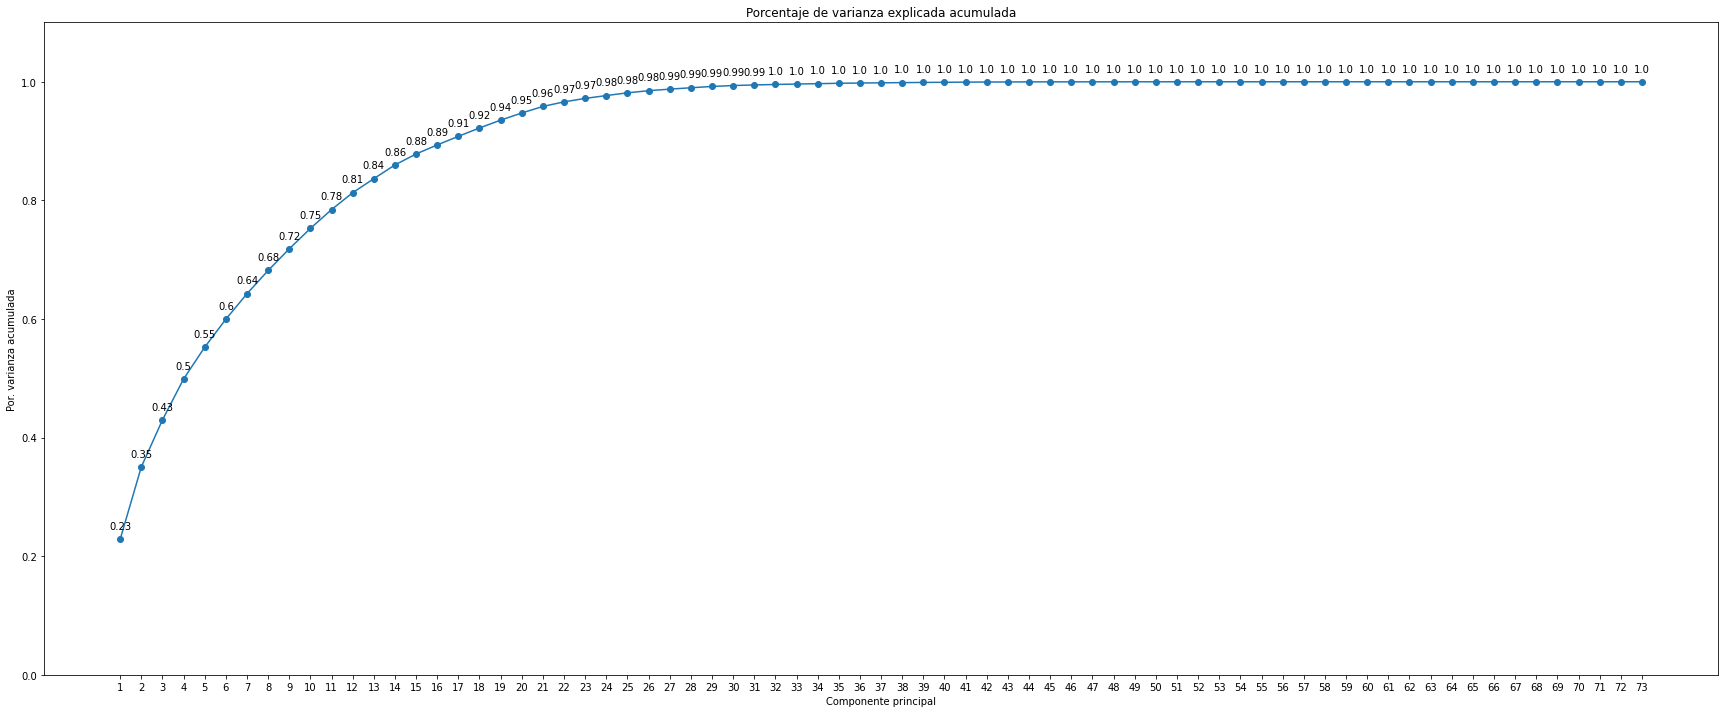

In [26]:
# Porcentaje de varianza explicada acumulada
# ==============================================================================
prop_varianza_acum = modelo_pca.explained_variance_ratio_.cumsum()
print('------------------------------------------')
print('Porcentaje de varianza explicada acumulada')
print('------------------------------------------')
print(prop_varianza_acum)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30, 12))
ax.plot(
    np.arange(len(features_ones.columns)) + 1,
    prop_varianza_acum,
    marker = 'o'
)

for x, y in zip(np.arange(len(features_ones.columns)) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
    
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada');

Aquí, podemos observar cual es la varianza acumulada explicada. Por ejemplo:

 * Eje $x = 1$: la primera componente explica el 23% de la varianza de los datos
 * Eje $x = 2$: la primera y segunda componente explican el 35% de la varianza de los datos
 * Eje $x = 3$: la primera, segunda y componente componente explican el 43% de la varianza de los datos
 * etc

### 2.3.4 Selección del número de componentes

Si se empleasen únicamente las 16 primeras componentes se conseguiría explicar casi el 90% de la varianza observada.  De todos modos, con solo 10 variables, ya podemos explicar el 75% de la varianza observada. 

Para asegurar un poco más el tiro, nos quedaremos con $n$ variables tales que el porcentaje de varianza explicada acumulada sea 90%. 

In [33]:
n_pca_comp =  sum(prop_varianza_acum <= 0.90)
print("Número de CP: ", n_pca_comp)

Numero de CP:  16


Efectivamente 16 no son pocas pero tampoco son las 73 que teniamos inicialmente. Parece ser una buena cifra :) 